Descarga de tabla de empresas en el sp500

In [1]:
import urllib.request
from html_table_parser import HTMLTableParser
import pandas as pd
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import mplfinance as mpf
mpf.__version__

'0.12.9b1'

In [2]:
# Funcion para obtener contenido de un sitio web
def url_get_contents(url):
    req = urllib.request.Request(url = url)
    f = urllib.request.urlopen(req)
    return f.read()

In [3]:
# Enlace
xhtml = url_get_contents('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').decode('utf-8') 
p = HTMLTableParser()
p.feed(xhtml)

In [4]:
col = ['Security', 'Sector']

stocks = {
    "Security" : [],
    "Sector" : []
}

Symbol = []

In [5]:
first = False
for company in p.tables[0]:
    if first:
        stocks['Security'].append(company[1])
        stocks['Sector'].append(company[3])
        Symbol.append(company[0])
        pass
    else:
        first = True

In [6]:
sp500 = pd.DataFrame(stocks,
    index = Symbol,
    columns = col
    )

In [7]:
sp500.head()

,Security,Sector
MMM,3M,Industrials
AOS,A. O. Smith,Industrials
ABT,Abbott,Health Care
ABBV,AbbVie,Health Care
ABMD,Abiomed,Health Care


In [8]:
sp500.drop('CEG', inplace=True)

In [9]:
#sp500 = sp500[:50]

Obtener el historial de precios

In [10]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

In [11]:
# array de historial
stocks_history = []

# Inicializamos los data frame
z = pdr.get_data_yahoo('zzz', start="2000-01-01", end="2021-12-31")
for i in range(0,sp500.index.shape[0]):
    stocks_history.append(z)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ZZZ: No data found, symbol may be delisted


In [16]:
# Añadimos excepciones
stocks_history[64] = (pdr.get_data_yahoo('BRK-B', start="2000-01-01", end="2021-12-31"))
stocks_history[80] = (pdr.get_data_yahoo('BF-B', start="2000-01-01", end="2021-12-31"))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
# download dataframe
#samples = 0
for idx, symbol in enumerate(sp500.index):
    if stocks_history[idx].shape[0] == 0:
        stocks_history[idx] = pdr.get_data_yahoo(symbol, start="2000-01-01", end="2021-12-31")
        #samples+=1
    #else:
    #    break


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Agregar columnas para analisis

In [14]:
stocks_history[25].index.day_name()

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       ...
       'Thursday', 'Friday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday'],
      dtype='object', name='Date', length=5535)

In [17]:
for idx, stock in enumerate(stocks_history):
    #print(idx)
    # Columna del dia de la semana: DayOfWeek
    stocks_history[idx]['DayOfWeek'] = stocks_history[idx].index.day_name()

    # Columna de los retornos gap_logs
    stocks_history[idx]['retornos_gaps_logs'] =np.log(stocks_history[idx].Open/stocks_history[idx].Close.shift(1)).fillna(0)

    # Columna de los retornos gap
    stocks_history[idx]['retornos_gaps'] = (stocks_history[idx].Open/stocks_history[idx].Close.shift(1)).fillna(0)

    #mmm['retorno_intradia'] = np.log(mmm.Close/mmm.Open).fillna(0)
    # Retorno Intraday Log
    stocks_history[idx]['intraday_log'] =np.log(stocks_history[idx].Close/stocks_history[idx].Open).fillna(0)
    # Retorno Intraday
    stocks_history[idx]['intraday'] =(stocks_history[idx].Close/stocks_history[idx].Open).fillna(0)

In [18]:
# Producto de un array
def producto_array(l):
    producto = 1
    for i in l:
        producto*=i
    return producto

Rendimiento gap e intradia

In [19]:
# Matrices de rendimiento gap
rGap = np.zeros((len(stocks_history),5))
rGapLog = np.zeros((len(stocks_history),5))

# Matrices rendimiento intradiario
rIntra = np.zeros((len(stocks_history),5))
rIntraLog = np.zeros((len(stocks_history),5))

# Dias de la semana
dias = np.array(['Monday','Tuesday','Wednesday','Thursday','Friday'])

In [20]:
# r_gap[idx] = mmm.retornos_gaps_logs[mmm.DayOfWeek == day][1:].sum()
for idx, stock in enumerate(stocks_history):
    for idy, day in enumerate(dias):
        # Rendimientos gap
        rGap[idx][idy] = stock.retornos_gaps_logs[stock.DayOfWeek == day][1:].sum()
        #rGapLog[idx][idy] = producto_array(stock.retornos_gaps[stock.DayOfWeek == day][1:])

        # Rendimientos intradiario
        rIntra[idx][idy] = stock.intraday_log[stock.DayOfWeek == day][1:].sum()
        #rIntraLog[idx][idy] = producto_array(stock.intraday[stock.DayOfWeek == day][1:])

In [21]:
rGapLog-=1

Boxplot dias mas rentables

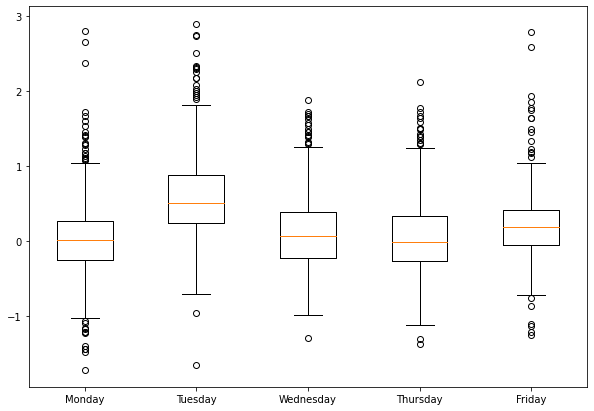

In [22]:
# gap
fig = plt.figure(figsize =(10, 7))
plt.boxplot(rGap)
plt.xticks([1,2,3,4,5], dias)

# gapLog
#fig1 = plt.figure(figsize =(10, 7))
#plt.boxplot(rGapLog)
#plt.xticks([1,2,3,4,5], dias)

plt.show()

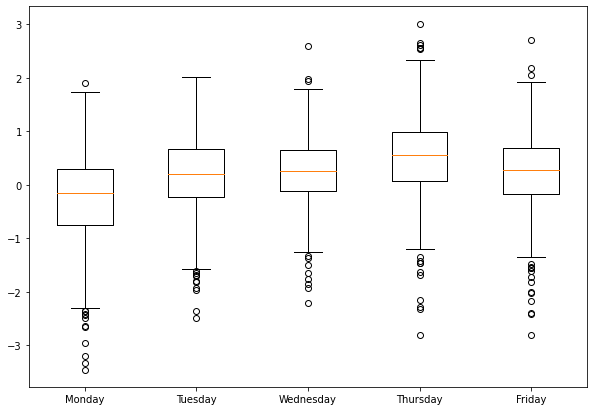

In [23]:
# intraday
fig = plt.figure(figsize =(10, 7))
plt.boxplot(rIntra)
plt.xticks([1,2,3,4,5], dias)

# intraday Log
#fig1 = plt.figure(figsize =(10, 7))
#plt.boxplot(rIntraLog)
#plt.xticks([1,2,3,4,5], dias)

plt.show()

Indice de volatilidad

In [24]:
#mmm['Variaciones'] = mmm['Adj Close'].pct_change()
#mmm['Volatilidad'] = mmm.Variaciones.rolling(250).std()*100*(250)**0.5

for idx, stock in enumerate(stocks_history):
    variaciones = stock['Adj Close'].pct_change()
    stocks_history[idx]['Volatilidad'] = variaciones.rolling(250).std()*100*(250)**0.5

In [25]:
stocks_history[0].head()

,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,retornos_gaps_logs,retornos_gaps,intraday_log,intraday,Volatilidad
Date,,,,,,,,,,,,
2000-01-03,48.03125,48.25000,47.03125,47.1875,26.434849,2173400,Monday,0.000000,0.000000,-0.017723,0.982433,NaN
2000-01-04,46.43750,47.40625,45.31250,45.3125,25.384468,2713800,Tuesday,-0.016022,0.984106,-0.024524,0.975774,NaN
2000-01-05,45.56250,48.12500,45.56250,46.6250,26.119740,3699400,Wednesday,0.005502,1.005517,0.023052,1.023320,NaN
2000-01-06,47.15625,51.25000,47.15625,50.3750,28.220516,5975800,Thursday,0.011330,1.011394,0.066028,1.068257,NaN
2000-01-07,50.56250,51.90625,49.96875,51.3750,28.780733,4101200,Friday,0.003715,1.003722,0.015941,1.016069,NaN


In [26]:
sp500.index[0:13]

Index(['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE',
       'ADP', 'AAP', 'AES', 'AFL'],
      dtype='object')

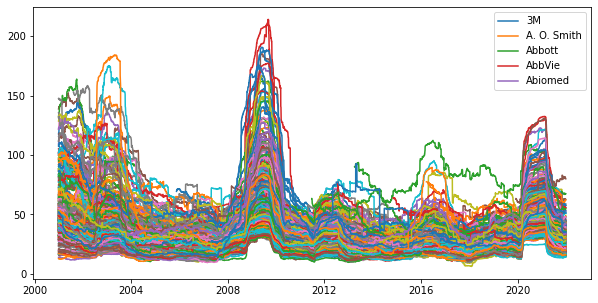

In [27]:
# Indice de volatilidad
fig = plt.figure(figsize =(10, 5))
for idx, stock in enumerate(stocks_history):
    plt.plot(stock.index ,stock.Volatilidad)
plt.legend(sp500.Security[0:5])
plt.show()

DataFrame de volatilidad

In [28]:
data1 = {
    'MMM' : list(stocks_history[0].Volatilidad)
}

volatilidad = pd.DataFrame(data1,
    index = stocks_history[0].index,
    columns = ['MMM']
    )

In [29]:
for idx, stock in enumerate(stocks_history):
    volatilidad[sp500.index[idx]] = stocks_history[idx].Volatilidad

C:\Users\exort\AppData\Local\Temp\ipykernel_11684\3029929136.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volatilidad[sp500.index[idx]] = stocks_history[idx].Volatilidad
C:\Users\exort\AppData\Local\Temp\ipykernel_11684\3029929136.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volatilidad[sp500.index[idx]] = stocks_history[idx].Volatilidad
C:\Users\exort\AppData\Local\Temp\ipykernel_11684\3029929136.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [30]:
#volatilidad = volatilidad.fillna(0)

In [31]:
volatilidad.iloc[245:255]

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-28,36.164381,39.390970,39.131193,NaN,96.567490,NaN,80.692549,36.914556,88.300713,38.135286,...,NaN,48.621257,NaN,28.565687,NaN,50.181297,70.629080,NaN,51.709304,NaN
2000-12-29,35.952726,39.372128,39.014349,NaN,96.624147,NaN,80.646634,36.975409,88.063966,38.135700,...,NaN,48.594431,NaN,28.491526,NaN,50.157899,70.975542,NaN,51.472054,NaN
2001-01-02,35.867792,39.385431,39.021386,NaN,96.913333,NaN,80.998490,37.030026,90.310418,38.177703,...,NaN,48.587285,NaN,28.389241,NaN,50.258999,71.055972,NaN,51.637285,NaN
2001-01-03,35.000193,39.537853,38.950876,NaN,97.346329,NaN,81.319607,37.290305,93.352103,38.222047,...,NaN,48.766605,NaN,28.609461,NaN,50.571637,71.661670,NaN,51.721400,NaN


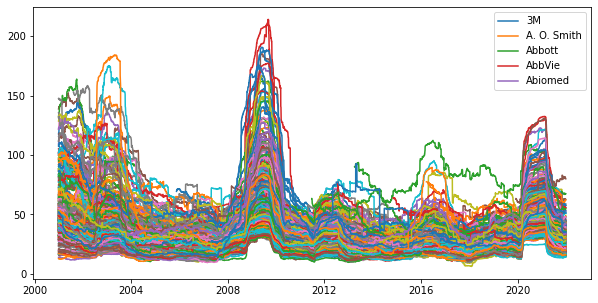

In [32]:
# Indice de volatilidad ponderado
fig = plt.figure(figsize =(10, 5))
for idx, stock in enumerate(stocks_history):
    plt.plot(stock.index[250:] ,stock.Volatilidad[250:])
plt.legend(sp500.Security[0:5])
plt.show()

Factores de ponderacion de stocks

In [33]:
# dataframe de factores para ponderacion
weight = copy.copy(volatilidad)

In [34]:
volatilidad.columns

Index(['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE',
       'ADP',
       ...
       'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', length=502)

In [11]:
# Vector de factores de ponderacion
marketCap = np.zeros((sp500.shape[0],1))

# Obtener la capitalizacion de mercado de cada empresa
for idx, stock in enumerate(sp500.index):
    print(idx)
    marketCap[idx] = yf.Ticker(stock).info['marketCap']

# Convertir array en data frame
df = pd.DataFrame(marketCap)

# Guardar pesos en un csv porque es muy tardado descargar los datos
df.to_csv('marketCap.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
#c= marketCap[marketCap > 0]
#np.median(c)

27299205120.0

In [24]:
# Cargamos csv de marketCap
marketCap = pd.read_csv('marketCap.csv')

# Eliminamos nulos con la media
marketCap['0'] = marketCap['0'].fillna(27299205120.0)

# Lo guardamos en un array
marketCap = np.array(p['0'])



In [ ]:
weight.iloc[245:255]

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,APH,ADI,ANSS,AON,APA,AAPL,AMAT,APTV,ANET,AJG
Date,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-28,36.164397,39.390941,39.131165,NaN,96.567490,NaN,80.692535,36.914681,88.300736,38.135251,...,77.273673,93.864757,53.575320,62.834387,53.112988,87.039129,84.267737,NaN,NaN,46.862817
2000-12-29,35.952740,39.372100,39.014318,NaN,96.624147,NaN,80.646620,36.975529,88.063983,38.135665,...,77.840105,93.873355,54.258728,62.797187,53.101826,86.663179,84.183093,NaN,NaN,46.940462
2001-01-02,35.867809,39.385402,39.021354,NaN,96.913333,NaN,80.998481,37.030137,90.310443,38.177665,...,77.840702,94.242453,54.432031,62.763054,53.046829,86.645411,84.172440,NaN,NaN,46.965209
2001-01-03,35.000201,39.537824,38.950850,NaN,97.346329,NaN,81.319601,37.290427,93.352139,38.222009,...,77.821429,95.501960,54.452699,62.688127,52.705619,86.861597,87.992997,NaN,NaN,47.109626


In [ ]:
for idx, fecha in enumerate(weight.index):
    weight.iloc[idx] += marketCap
    mask = weight.iloc[idx].index[weight.iloc[idx] > 0]
    weight.loc[fecha, mask] /= weight.loc[fecha, mask].sum()

In [ ]:
## Rellenamos los espacios NaN con 0 para poder hacer el producto punto

# Dataframe auxiliar
aux = copy.copy(volatilidad.fillna(0))

# weights
weight = weight.fillna(0)

In [ ]:
# Vector de volatilidad ponderado
v = np.zeros((weight.shape[0],1))

# Multiplicar peso por indice de volatilidad
for idx in range(0,weight.shape[0]):
    v[idx] = np.dot(aux.iloc[idx], weight.iloc[idx])

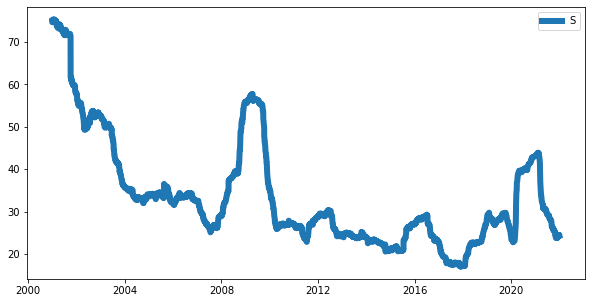

In [ ]:
fig = plt.figure(figsize =(10, 5))
plt.plot(volatilidad.index[250:] ,v[250:], linewidth=6)
plt.legend('S&P 500')
plt.show()

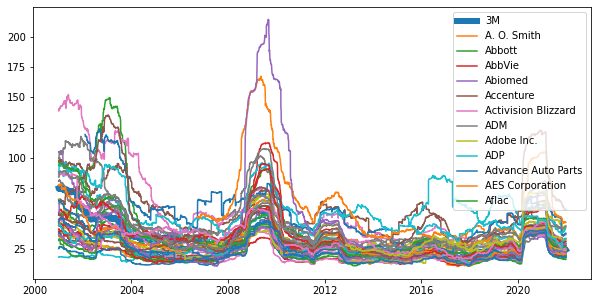

In [ ]:
# Indice de volatilidad ponderado
fig = plt.figure(figsize =(10, 5))
plt.plot(volatilidad.index[250:] ,v[250:], linewidth=6)
for idx, stock in enumerate(stocks_history):
    plt.plot(stock.index ,stock.Volatilidad)
plt.legend(sp500.Security[0:13])
plt.show()

Descargar y tranformar datos del S&P 500

In [ ]:
sp = yf.download('ES=F', start="2000-01-01", end="2021-12-31", threads = True)

# Columna del dia de la semana: DayOfWeek
sp['DayOfWeek'] = sp.index.day_name()

# Columna de los retornos gap_logs
sp['retornos_gaps'] =np.log(sp.Open/sp.Close.shift(1)).fillna(0)

# Retorno Intraday
sp['intraday_log'] =np.log(sp.Close/sp.Open).fillna(0)

# Calculo de volatilidad
variaciones = stock['Adj Close'].pct_change()
sp['Volatilidad'] = variaciones.rolling(250).std()*100*(250)**0.5

[*********************100%***********************]  1 of 1 completed


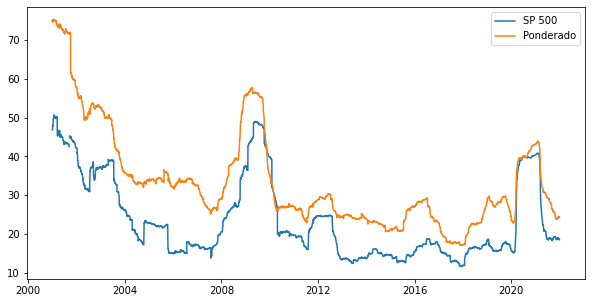

In [ ]:
# Comparacion Indice de volatilidad ponderado con Indice de volatilidad S&P 500
fig = plt.figure(figsize =(10, 5))
plt.plot(sp.index,sp.Volatilidad)
plt.plot(volatilidad.index[250:] ,v[250:])#, linewidth=6)
# Legends
legends = ['SP 500', 'Ponderado']
plt.legend(legends)
plt.show()

In [ ]:
# Imprimimos el grafico del S&P 500 con el indice de volatilidad ponderado
sp_copy = copy.copy(sp)
sp_copy['Volume'] = v[154:]

c:\Users\exort\AppData\Local\Programs\Python\Python39\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


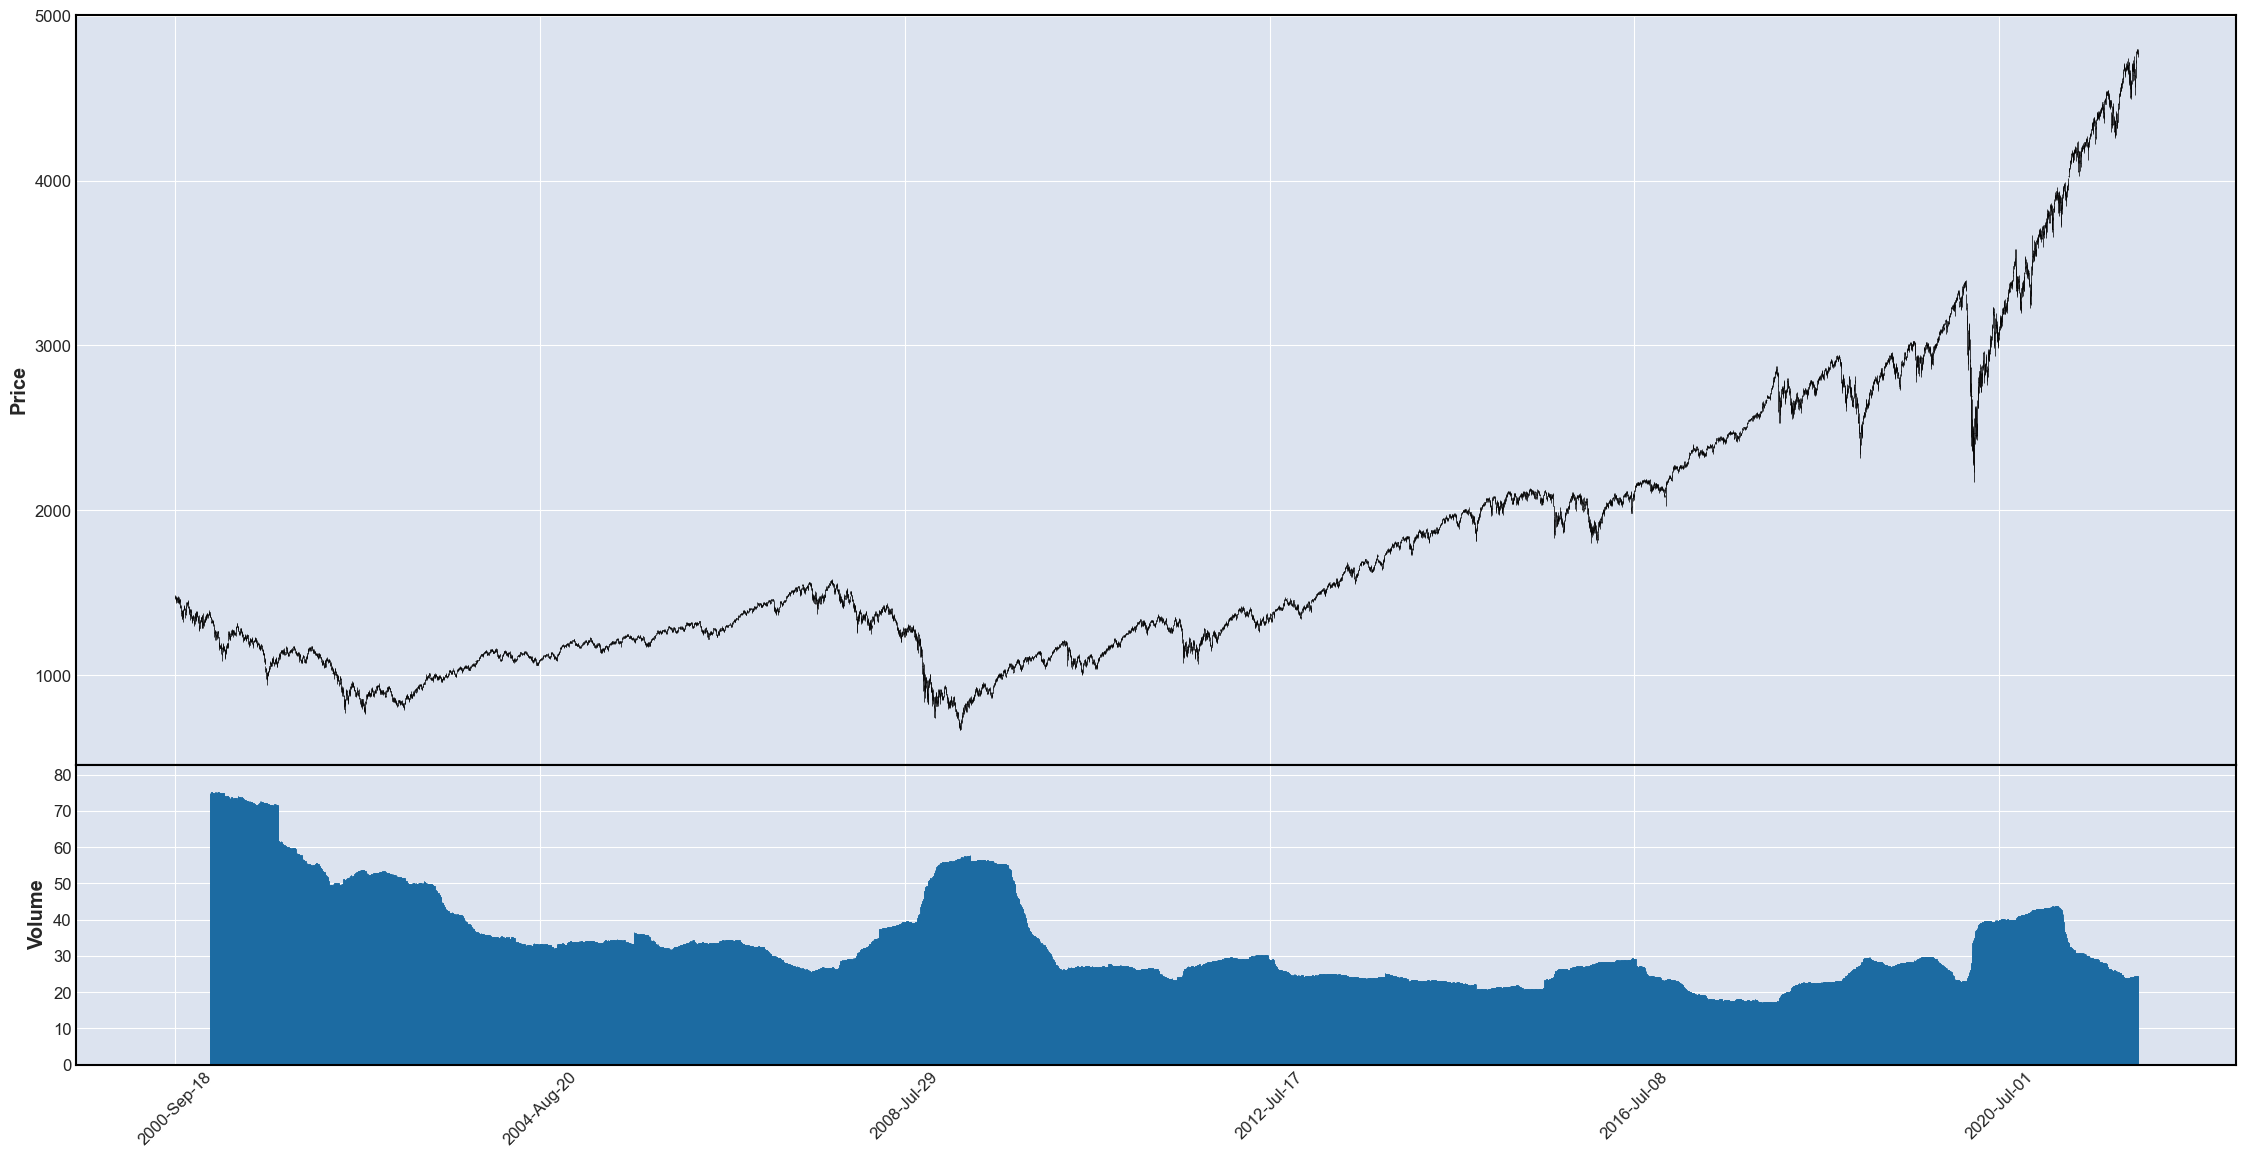

In [ ]:
#fig = plt.figure(figsize =(30, 15))
mpf.plot(sp_copy,volume=True,figsize =(30, 15))

Sector mas rentable del S&P 500

In [ ]:
# Vamos a hacer una suma en el rendimiento
sector = sp500.Sector.unique()

# dataframe auxiliar
aux = sp500.reset_index()

In [ ]:
sector

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy'], dtype=object)

In [ ]:
# Calculamos el tamaño necesario de la matriz de rendimientos por sector
m = 0
for i in sector:
    if sp500[sp500.Sector == i].shape[0] > m:
        m = sp500[sp500.Sector == i].shape[0]
m

11

In [ ]:
# Declaramos el array de rendimiento
rendimiento_sector = np.zeros((m,sector.shape[0]))

In [ ]:
# Calculamos el retorno por sector para los gaps
for idx, sec in enumerate(sector):
    s = aux.index[sp500.Sector == sec]
    for idy, company in enumerate(s):
        rendimiento_sector[idy, idx] = stocks_history[company].retornos_gaps_logs.sum()

In [ ]:
for idx in range(0,rendimiento_sector.shape[1]):
    rendimiento_sector[:,idx][rendimiento_sector[:,idx] == 0] = np.median(rendimiento_sector[:,idx][rendimiento_sector[:,idx] != 0])

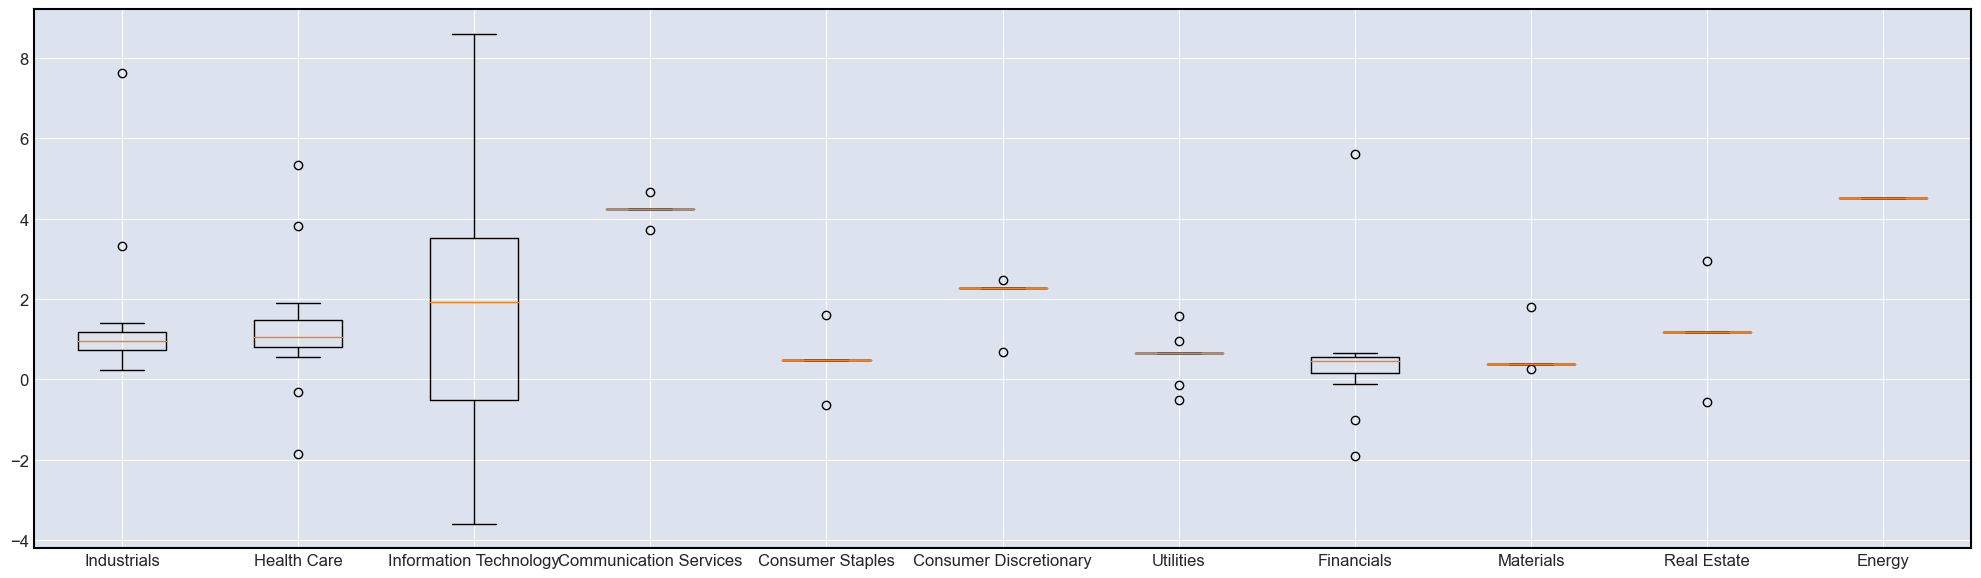

In [ ]:
# Rendimiento por sector
fig = plt.figure(figsize =(25, 7))
plt.boxplot(rendimiento_sector)

plt.xticks([1,2,3,4,5,6,7,8,9,10,11], sector)
plt.show()

Mejores empresas para invertir

Estrategia gap

In [ ]:
# Encontraremos las mejores acciones para invertir con la estrategia gap el dia martes, pues es el mejor dia para invertir en gap
#stock.retornos_gaps_logs[stock.DayOfWeek == day][1:].sum()

# Declaramos vector de desviacion estandar
std = np.zeros((len(stocks_history),1))
# Declaramos vector de rendimiento
rend = np.zeros((len(stocks_history),1))
# Declaramos vector de resultados rend/des_std
rend_std = np.zeros((len(stocks_history),1))
# indices
indx = np.array(list(range(0,len(stocks_history))))

for idx, stock in enumerate(stocks_history):
    std[idx] = stock.retornos_gaps_logs[stock.DayOfWeek == 'Tuesday'][1:].std()**0.5
    rend[idx] = stock.retornos_gaps_logs[stock.DayOfWeek == 'Tuesday'][1:].sum()

rend_std = rend/std

idx_companies = []

amount_companies = 2

for i in range(0,amount_companies):
    idx_companies.append(indx[rend_std == max(rend_std)])
    indx[rend_std == max(rend_std)] = 0

best_companies = sp500.index[]